# Model comparison

First, we will train two baseline models - the model with the masked protected variable and the model with the unmasked protected variable. We then wish to:
 - Compute feature importances

Then, we will train the best configurations with gamma sweeps. Using the gamma information, we find the best model-gamma pair. We will load those models and compute their feature importances as well.

This will give us insight into what happens to the protected variable in terms of feature importance

## Model training

In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tools.bias_utils import add_demographic_data, to_dmatrix
from tools.loss_functions import get_distance_corrected_mse, get_pearson_corrected_mse, get_kendalls_corrected_mse
from sklearn.metrics import r2_score

%matplotlib inline

In [3]:
model_paths = list(Path('../base_models/xgb/').glob('*.model'))

loss_dict = {'pearson': get_pearson_corrected_mse, 'kendall': get_kendalls_corrected_mse, 'distance': get_distance_corrected_mse}

In [4]:
# Generate a dictionary to maintain mapping state.
model_list = [[model] + model.name.replace('.model', '').split('_')[-2:] for model in model_paths]

## Update: We are not interested in the percentage models anymore.
model_list = list(filter(lambda x: x[1] != 'percentage', model_list))

print(model_list)

[[PosixPath('../base_models/xgb/base_xgb_percentile_masked.model'), 'percentile', 'masked'], [PosixPath('../base_models/xgb/base_xgb_percentile_unmasked.model'), 'percentile', 'unmasked']]


In [5]:
## Used from gamma_sweeps.py

def process_for_training(demographic, use_percentage=False, unmask=False):
    # if you are using different data, you will need to replace raw_data_train, raw_data_test files 
    # Inputs: The demographic column you be using for measuring bias
    # Ouputs: sends back matrix formated train and test vectors along with target test (y_test) and demographic test set (dem_test)

    # Load data
    # os_print('Loading data...')
    # these columns will be dropped for training
    cols_drop = ['Date', 'FC', 'PenRate', 'NumberOfLanes', 'Dir', 'Lat', 'Long']
    
    ########################################
    # REPLACE BELOW IF USING DIFFERENT DATA
    #########################################
    raw_data_train = pd.read_csv("../data/final_train_data.csv") 
    raw_data_test = pd.read_csv("../data/final_test_data.csv")
    raw_data_test1 = pd.DataFrame(np.concatenate((raw_data_test.values, np.zeros(raw_data_test.shape[0]).reshape(-1, 1)), axis=1),
                                    columns = raw_data_test.columns.append(pd.Index(['fold'])))
    raw_data = pd.DataFrame(np.concatenate((raw_data_train.values, raw_data_test1.values), axis=0), 
                            columns = raw_data_train.columns)

    #This will append new column with demographic data
    raw_data = add_demographic_data(
        raw_data, demographic, loc='../data/off_freeway_station_demographics.csv', use_percentage=use_percentage
    )
    
    # drop NA values
    raw_data = raw_data.dropna() 
    # Fold == 0 is testing, otherwise rest is training set
    raw_data_train = raw_data.loc[raw_data.fold!=0, :] 
    raw_data_test = raw_data.loc[raw_data.fold==0, :] 

    data = raw_data.drop(cols_drop, axis=1)  
    # for road directions, one-hot encoding is performed
    if 'Dir' in data.columns:
        one_hot = pd.get_dummies(data[['Dir']])
        data = data.drop(['Dir'], axis = 1)
        data = data.join(one_hot)
    # replace string weekdays with numbered days
    week_dict = {"DayOfWeek": {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                                'Friday': 5, 'Saturday': 6, 'Sunday': 7}}
    data = data.replace(week_dict)

    X = data.drop(['Volume'], axis=1) # drop target
    y = data[['Volume']]
    
    # convert to dmatrix. This is the format xgboost uses and set the input training set and target training set
    X_train = X.loc[X.fold!=0, :]
    X_train = X_train.drop(['fold', 'StationId'], axis = 1).values
    y_train = y.loc[X.fold!=0, :].values
    dtrain = to_dmatrix(X_train, y_train, unmask_protected=unmask)  

    # convert to dmatrix. This is the format xgboost uses. Also, sets the demographic test set and input and target test sets
    X_test = X.loc[X.fold==0, :]
    dem_test = X_test[[demographic]].values.flatten()
    X_test = X_test.drop(['fold', 'StationId'], axis = 1).values
    y_test = y.loc[X.fold==0, :].values.flatten()
    dtest = to_dmatrix(X_test, y_test, unmask_protected=unmask) 

    return dtrain,dtest,y_test,dem_test

In [6]:
results = pd.DataFrame(
    {
        'mask': [None for _ in range(2)],
        'scale': [None for _ in range(2)],
        'mse': [np.nan for _ in range(2)],
        'rmse': [np.nan for _ in range(2)],
        'gamma': [np.nan for _ in range(2)],
        'r2': [np.nan for _ in range(2)]
    }
)

In [7]:
def train_model(params, dtrain, model_type, correction_type):
    
    # Initializing hyperparameters for each model below and trains on data
    objective = loss_dict[correction_type](0.0, etype=0)
    if model_type=='xgb':
        n_estimators = 100*int(params['n'])
        lr = 10**params['p']
        gamma = 10**params['g']
        depth = int(params['depth'])
        subsample = params['subsample']
        colsample = params['colsample']
        min_cw = params['min_cw']
        params = {'learning_rate':lr, 'max_depth':depth, 'n_jobs':-1, 'gamma':gamma, 'min_child_weight':min_cw,
            'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
        model = xgb.train(params, dtrain, num_boost_round=n_estimators, obj=objective)
    elif model_type == 'rf':
        n_estimators = 100*int(params['n'])
        depth = int(params['depth'])
        min_cw = params['min_cw']
        gamma = 10**params['g']
        subsample = params['subsample']
        colsample = params['colsample']
        params = {'n_estimators':n_estimators, 'max_depth':depth, 'nthread':-1, 'gamma':gamma, 'min_child_weight':min_cw,
                    'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
        model = RandomForestModel(**params)
        model.train(dtrain, obj=objective)
    elif model_type == 'gbt':
        n_estimators = 100*int(params['n'])
        lr = 10**params['p']
        depth = int(params['depth'])
        min_cw = params['min_cw']
        subsample = params['subsample']
        colsample = params['colsample']
        params = {'num_boost_round':n_estimators, 'eta':lr, 'max_depth':depth, 'nthread':-1, 'min_child_weight':min_cw,
                            'subsample':subsample, 'colsample_bytree':colsample, 'random_state':1234}
        model = GradientBoostedTreesModel(**params)
        model.train(dtrain, obj=objective)
    else:
        raise ValueError('Model type not recognized')

    return model

In [8]:
importances = list()

for ix, mtype in enumerate(model_list):
    scale_type = mtype[1]
    unmask_type = mtype[2]
    
    use_percentage = scale_type == 'percentage'
    unmask = unmask_type == 'unmasked'

    dtrain, dtest, y_test, dem_test = process_for_training('MINRTY', use_percentage, unmask)

    print(f"Data preprocessing for {use_percentage=} and {unmask=} done.")

    params_path = os.path.join('../', 'base_models', 'xgb', f'params_{scale_type}_{unmask_type}.json')
    with open(params_path) as f:
        params = json.load(f)

    model = train_model(params, dtrain, 'xgb', 'pearson')
    preds = model.predict(dtest).flatten()

    importances.append(model.get_score(importance_type='weight'))

    results.loc[ix, 'mask'] = unmask_type
    results.loc[ix, 'scale'] = scale_type
    results.loc[ix, 'gamma'] = 0.
    results.loc[ix, 'r2'] = r2_score(y_pred=preds, y_true=y_test)
    results.loc[ix, 'mse'] = np.mean((y_test - preds)**2)
    results.loc[ix, 'rmse'] = np.sqrt(np.mean((y_test - preds)**2))

Using key: EPL_
Data preprocessing for use_percentage=False and unmask=False done.
Using key: EPL_
Data preprocessing for use_percentage=False and unmask=True done.


Features = 

```
['Temp', 'WindSp', 'Precip', 'Snow', 'StationId', 'SpeedLimit', 'FRC',
       'DayOfWeek', 'Month', 'Hour', 'AvgSp', 'ProbeCount',
       'ProbeCountLastWeek', 'AvgProbeCountLastMonth', 'fold', 'MINRTY']
```

In [9]:
display(results.sort_values(by=['r2'], ascending=False))

,mask,scale,mse,rmse,gamma,r2
0,masked,percentile,9996.80780,99.984038,0.0,0.870092
1,unmasked,percentile,10256.97257,101.276713,0.0,0.866711


On the basis of simply RMSE or MSE, the masked benchmark model performs better than the unmasked model. The R2 is not off by much.

In [10]:
renaming = {'f'+str(ix): name for ix, name in enumerate(
    ['Temp', 'WindSp', 'Precip', 'Snow', 'SpeedLimit', 'FRC',
       'DayOfWeek', 'Month', 'Hour', 'AvgSp', 'ProbeCount',
       'ProbeCountLastWeek', 'AvgProbeCountLastMonth', 'MINRTY'
    ]
)}

print(renaming)

{'f0': 'Temp', 'f1': 'WindSp', 'f2': 'Precip', 'f3': 'Snow', 'f4': 'SpeedLimit', 'f5': 'FRC', 'f6': 'DayOfWeek', 'f7': 'Month', 'f8': 'Hour', 'f9': 'AvgSp', 'f10': 'ProbeCount', 'f11': 'ProbeCountLastWeek', 'f12': 'AvgProbeCountLastMonth', 'f13': 'MINRTY'}


In [11]:
imp = pd.DataFrame(importances).rename(columns=renaming)

In [12]:
# Normalize the importances.
imp1 = imp.div(imp.sum(axis=1), axis=0)

In [13]:
display(imp1)

,Temp,WindSp,Precip,SpeedLimit,FRC,DayOfWeek,Month,Hour,AvgSp,ProbeCount,ProbeCountLastWeek,AvgProbeCountLastMonth,MINRTY
0,0.119726,0.093852,0.016371,0.091150,0.053717,0.043919,0.056542,0.111130,0.122289,0.104348,0.079085,0.107870,NaN
1,0.110480,0.095652,0.010367,0.070914,0.048617,0.029583,0.040133,0.113488,0.108341,0.089006,0.062842,0.103331,0.117245


Clearly, we see that the `ProbeCount` and `AvgProbeCountLastMonth` features are extremely important to the models when predicting the volume. Even when we unmask the protected variable, it does not contribute to the regression (1.3%)

## Gamma Sweeps

Perform gamma sweeps (`gamma_sweeps.py`) and redirect here for further analysis.

In [14]:
# First, read the gamma CSVs.
# Again, we are NOT interested in percentages anymore.
gammas = list(Path('../results_xgb/pearson').glob('./*percentile*/*.csv'))

print(gammas)

[PosixPath('../results_xgb/pearson/MINRTY_percentile_masked/gamma_sweep.csv'), PosixPath('../results_xgb/pearson/MINRTY_percentile_unmasked/gamma_sweep.csv')]


In [15]:
# def get_best_gamma(gamma_df: pd.DataFrame, max_param: str, min_param: str):
#     '''
#     We want to find the best gamma that minimizes the R2 difference from the baseline and maximizes the R2.
#     This is a more robust, systematic, and error-free way to obtain the best gamma for the model.
#     '''

    
    
#     return best_ix, best_gamma

In [16]:
def get_data(df: pd.DataFrame):
    # Values obtained by referring to Joe's great visualization!
    x = df.gamma.values
    y1 = df.test_r2.values
    y2 = df['r2 diff 0.8'].values
    return x, y1, y2

In [17]:
# def onclick(event):
#     if event.xdata and event.ydata:
#         display(event.xdata, event.ydata)

In [18]:
def plot_gammas(csv_file, line_at=0.99):
    
    print(f"Reading {csv_file}")
    
    gamma = pd.read_csv(csv_file)
    gamma.sort_values(by=['gamma'], ascending=True, inplace=True)
    gamma.reset_index(drop=True, inplace=True)

    x, r2, r2_diff = get_data(gamma)

    # i, best_gamma = get_best_gamma(gamma, max_param='test_r2', min_param='r2 diff 0.8')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Gamma')
    ax1 = ax.twinx()
    ax.plot(x, r2, 'b-')
    ax1.plot(x, r2_diff, 'r-')

    # Crop-out the unncessary x range.
    ax.set_xlim(0.8, 1.)
    ymin, ymax = ax.get_ylim()
    
    # Get closest actual gamma.
    gamma_argmin = np.argmin(np.abs(line_at - x))

    ax.plot([line_at for _ in range(50)], np.linspace(ymin, ymax, 50), linewidth=1.5, c='black', ls='--')
    ax.set_ylabel('R2')
    ax1.set_ylabel('R2 difference')
    
    print(f"At {line_at}, gamma={x[gamma_argmin]}, R2={r2[gamma_argmin]}, R2 diff={r2_diff[gamma_argmin]}")
    
    plt.show()

Reading ../results_xgb/pearson/MINRTY_percentile_masked/gamma_sweep.csv
At 0.994, gamma=0.993787934606864, R2=0.8320338310393809, R2 diff=0.1424239398462636


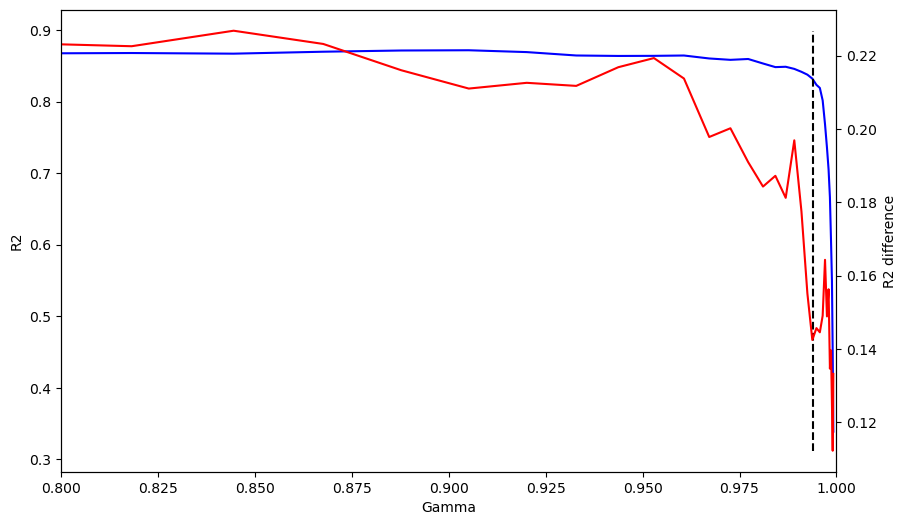

In [19]:
plot_gammas(gammas[0], line_at=0.994)

Reading ../results_xgb/pearson/MINRTY_percentile_unmasked/gamma_sweep.csv
At 0.973, gamma=0.9726502638090148, R2=0.8279557125772105, R2 diff=0.1444412423414873


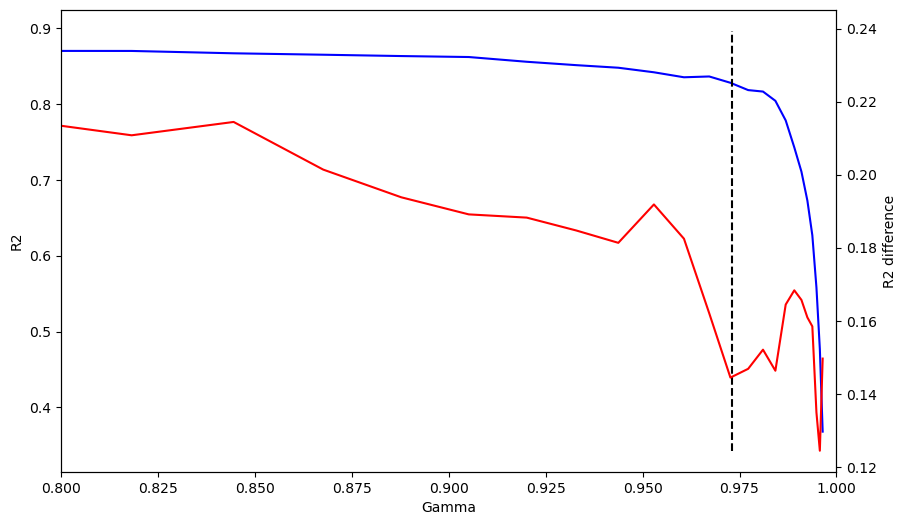

In [20]:
plot_gammas(gammas[1], line_at=0.973)

So now we know that:

Best gamma model for masked protected variable:


| Gamma | R2 | R2 diff 0.8 |
| ---- | ---- | ---------- |
| 0.993787934606864 | 0.83 | 0.14 |


<hr />

Best gamma model for unmasked protected variable:


| Gamma | R2 | R2 diff 0.8 |
| ---- | ---- | ---------- |
| 0.9726502638090148 | 0.83 | 0.14 |


In [21]:
# Let's load the two gamma models.
gamma_masked = ('percentile_masked', '0.993787934606864')
gamma_unmasked = ('percentile_unmasked', '0.9726502638090149')

models = list(Path('../results_xgb/pearson').glob('./*percentile*/models/*.model'))

In [22]:
masked_model = list(filter(
    lambda x: (gamma_masked[0] in str(x) and gamma_masked[1] in str(x)), 
    models
))[0]

unmasked_model = list(filter(
    lambda x: (gamma_unmasked[0] in str(x) and gamma_unmasked[1] in str(x)), 
    models
))[0]

In [23]:
masked_model, unmasked_model

(PosixPath('../results_xgb/pearson/MINRTY_percentile_masked/models/0.993787934606864.model'),
 PosixPath('../results_xgb/pearson/MINRTY_percentile_unmasked/models/0.9726502638090149.model'))

In [24]:
# These are already trained. We want to load them and visualize their feature importance.

masked_xgb, unmasked_xgb = xgb.Booster(), xgb.Booster()

masked_xgb.load_model(masked_model)
unmasked_xgb.load_model(unmasked_model)

In [31]:
importances = [masked_xgb.get_score(importance_type='weight'), unmasked_xgb.get_score(importance_type='weight')]
importance_df = pd.DataFrame(importances)

In [32]:
importance_df = pd.DataFrame(importance_df).rename(columns=renaming)

In [33]:
importance_df1 = importance_df.div(importance_df.sum(axis=1), axis=0)

In [34]:
display(imp1)

,Temp,WindSp,Precip,SpeedLimit,FRC,DayOfWeek,Month,Hour,AvgSp,ProbeCount,ProbeCountLastWeek,AvgProbeCountLastMonth,MINRTY
0,0.119726,0.093852,0.016371,0.091150,0.053717,0.043919,0.056542,0.111130,0.122289,0.104348,0.079085,0.107870,NaN
1,0.110480,0.095652,0.010367,0.070914,0.048617,0.029583,0.040133,0.113488,0.108341,0.089006,0.062842,0.103331,0.117245


In [35]:
display(importance_df1)

,Temp,WindSp,Precip,SpeedLimit,FRC,DayOfWeek,Month,Hour,AvgSp,ProbeCount,ProbeCountLastWeek,AvgProbeCountLastMonth,MINRTY
0,0.089251,0.048590,0.007475,0.081889,0.113263,0.051195,0.093329,0.133084,0.070223,0.108619,0.048703,0.154378,NaN
1,0.065004,0.034473,0.003759,0.066746,0.102686,0.021821,0.081049,0.128908,0.056386,0.107912,0.043917,0.161181,0.126158


### Observations

In [37]:
for col in imp1.columns:
    avg_before = np.nanmean(imp1[col])
    avg_after = np.nanmean(importance_df1[col])
    
    percent_change = np.abs(avg_before - avg_after)/avg_before
    trend = 'up' if avg_after > avg_before else 'down'
    
    print(f"For feature {col}, average importance goes {trend} by {percent_change * 100:.3f}%")

For feature Temp, average importance goes down by 32.992%
For feature WindSp, average importance goes down by 56.168%
For feature Precip, average importance goes down by 57.984%
For feature SpeedLimit, average importance goes down by 8.286%
For feature FRC, average importance goes up by 111.024%
For feature DayOfWeek, average importance goes down by 0.662%
For feature Month, average importance goes up by 80.376%
For feature Hour, average importance goes up by 16.639%
For feature AvgSp, average importance goes down by 45.103%
For feature ProbeCount, average importance goes up by 11.987%
For feature ProbeCountLastWeek, average importance goes down by 34.741%
For feature AvgProbeCountLastMonth, average importance goes up by 49.411%
For feature MINRTY, average importance goes up by 7.601%


In [46]:
# masked-only models
for col in imp1.columns:
    
    val_before = imp1.loc[0, col]
    val_after = importance_df1.loc[0, col]
    
    trend = 'up' if val_after > val_before else 'down'
    
    # 0 -> masked
    percent_change = np.abs(val_before - val_after)/val_before
    
    print(f"For feature {col}, importance goes {trend} by {percent_change * 100:.3f}%")

For feature Temp, importance goes down by 25.454%
For feature WindSp, importance goes down by 48.227%
For feature Precip, importance goes down by 54.339%
For feature SpeedLimit, importance goes down by 10.160%
For feature FRC, importance goes up by 110.851%
For feature DayOfWeek, importance goes up by 16.568%
For feature Month, importance goes up by 65.062%
For feature Hour, importance goes up by 19.755%
For feature AvgSp, importance goes down by 42.576%
For feature ProbeCount, importance goes up by 4.093%
For feature ProbeCountLastWeek, importance goes down by 38.417%
For feature AvgProbeCountLastMonth, importance goes up by 43.114%
For feature MINRTY, importance goes down by nan%


In [47]:
# unmasked-only models
for col in imp1.columns:
    
    val_before = imp1.loc[1, col]
    val_after = importance_df1.loc[1, col]
    
    trend = 'up' if val_after > val_before else 'down'
    
    # 0 -> masked
    percent_change = np.abs(val_before - val_after)/val_before
    
    print(f"For feature {col}, importance goes {trend} by {percent_change * 100:.3f}%")

For feature Temp, importance goes down by 41.162%
For feature WindSp, importance goes down by 63.960%
For feature Precip, importance goes down by 63.740%
For feature SpeedLimit, importance goes down by 5.877%
For feature FRC, importance goes up by 111.216%
For feature DayOfWeek, importance goes down by 26.239%
For feature Month, importance goes up by 101.950%
For feature Hour, importance goes up by 13.587%
For feature AvgSp, importance goes down by 47.955%
For feature ProbeCount, importance goes up by 21.242%
For feature ProbeCountLastWeek, importance goes down by 30.115%
For feature AvgProbeCountLastMonth, importance goes up by 55.985%
For feature MINRTY, importance goes up by 7.601%


### After this, go to the bias_model_testing.ipynb notebook and generate the visualizations.

baseline + masked:

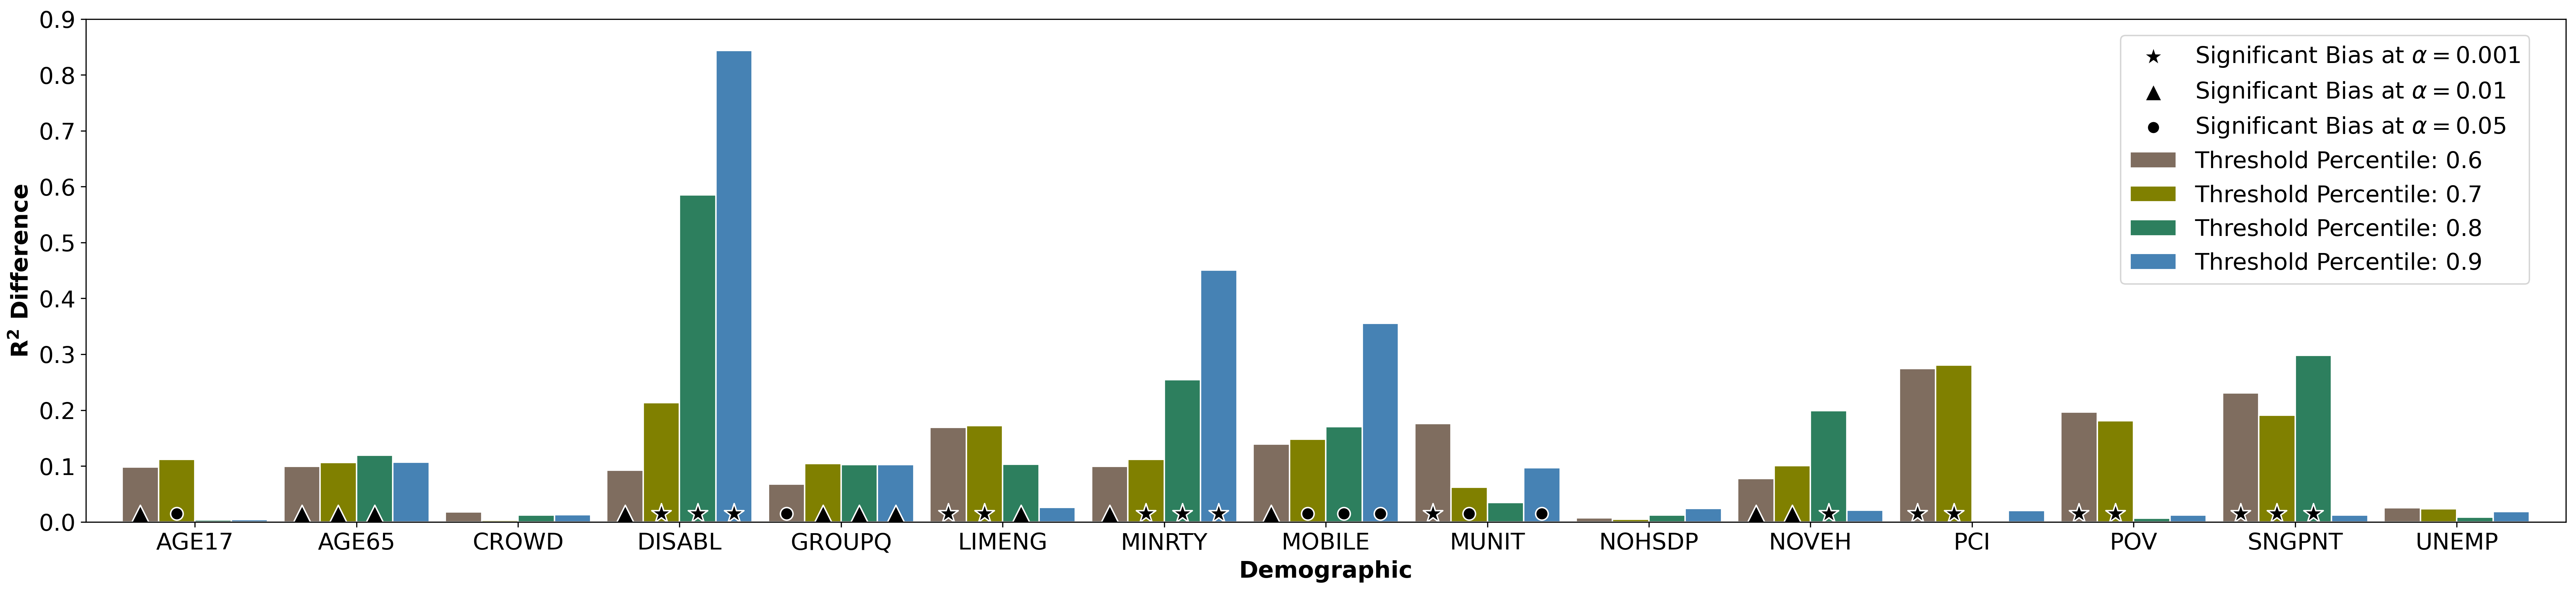

baseline + unmasked:

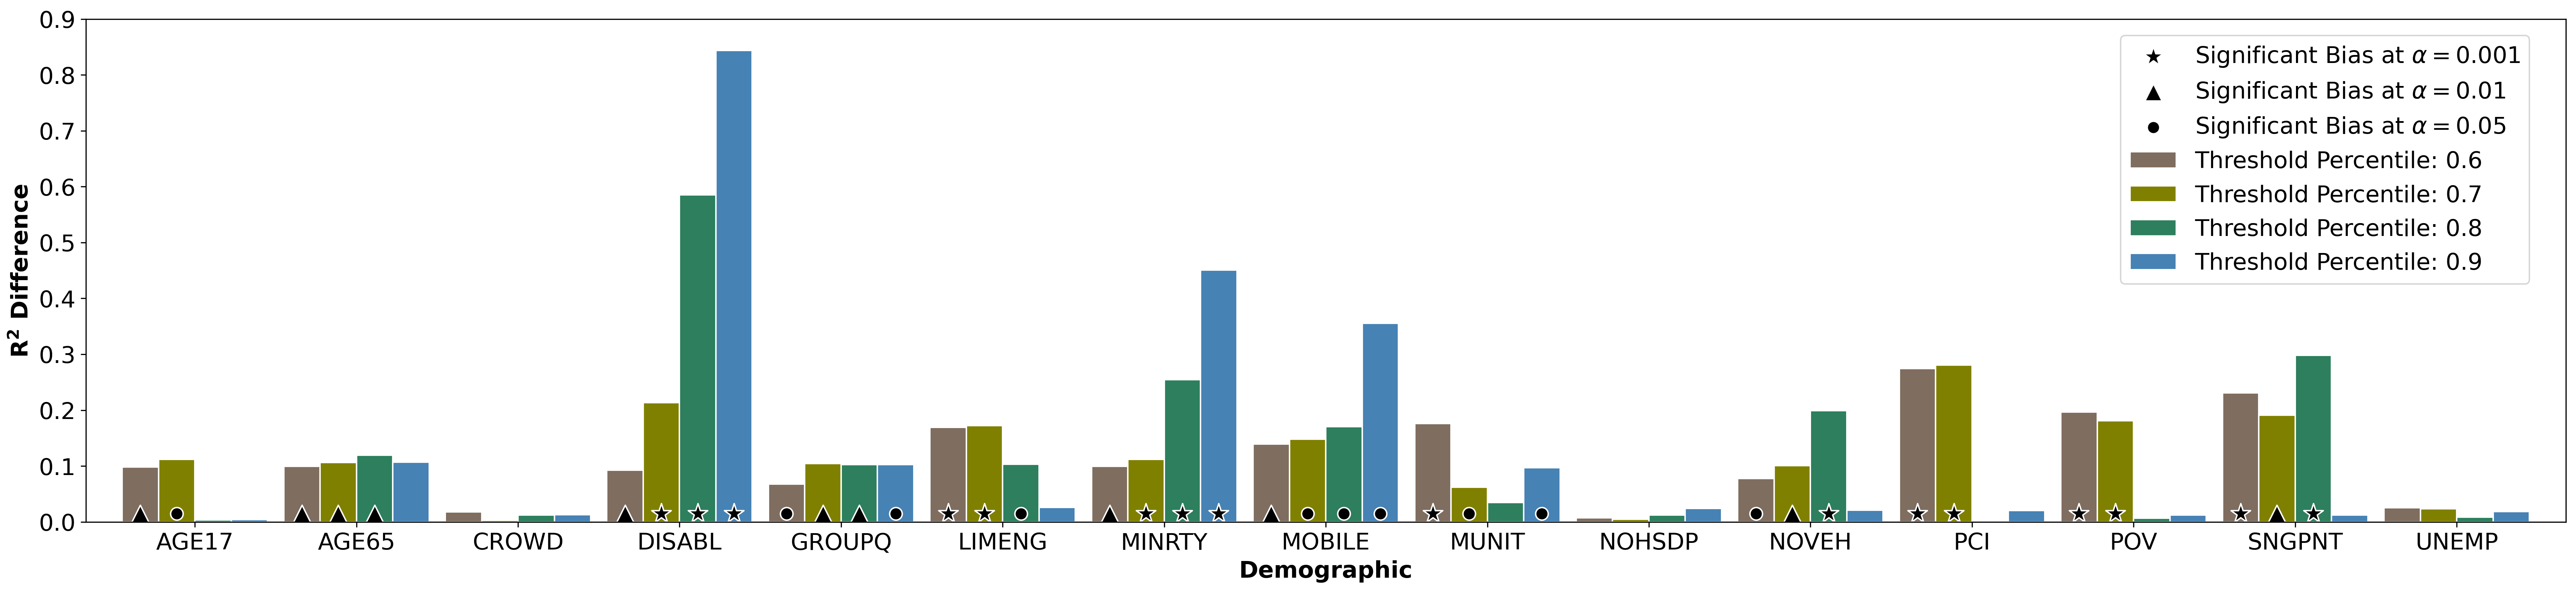

gamma + masked:

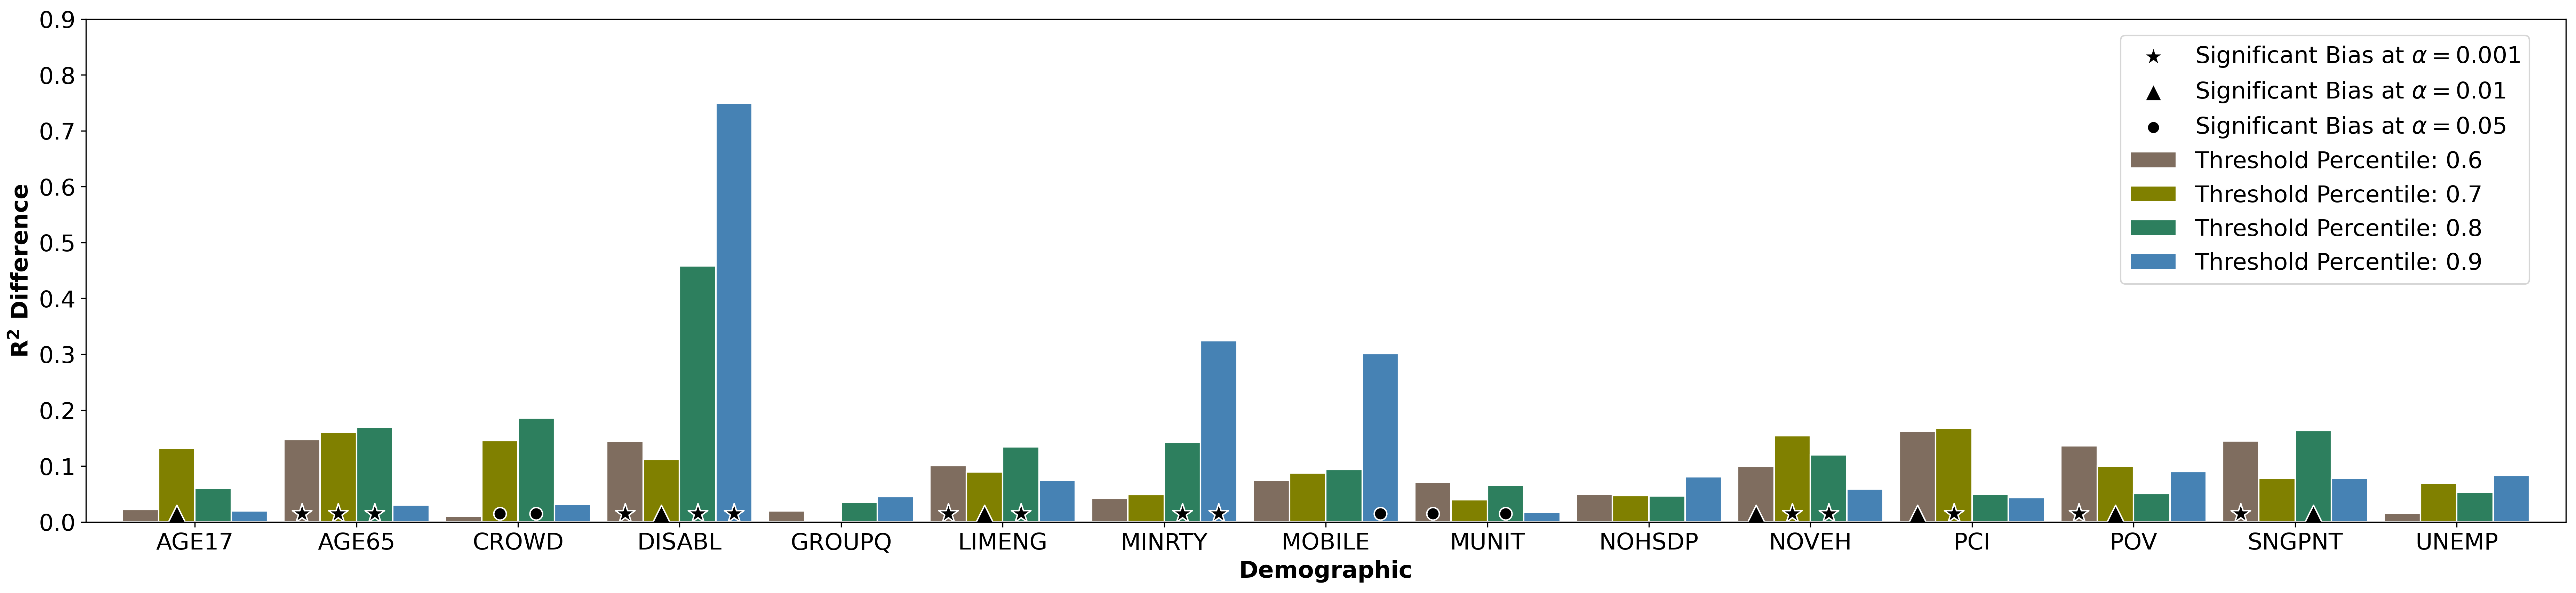

gamma + unmasked:

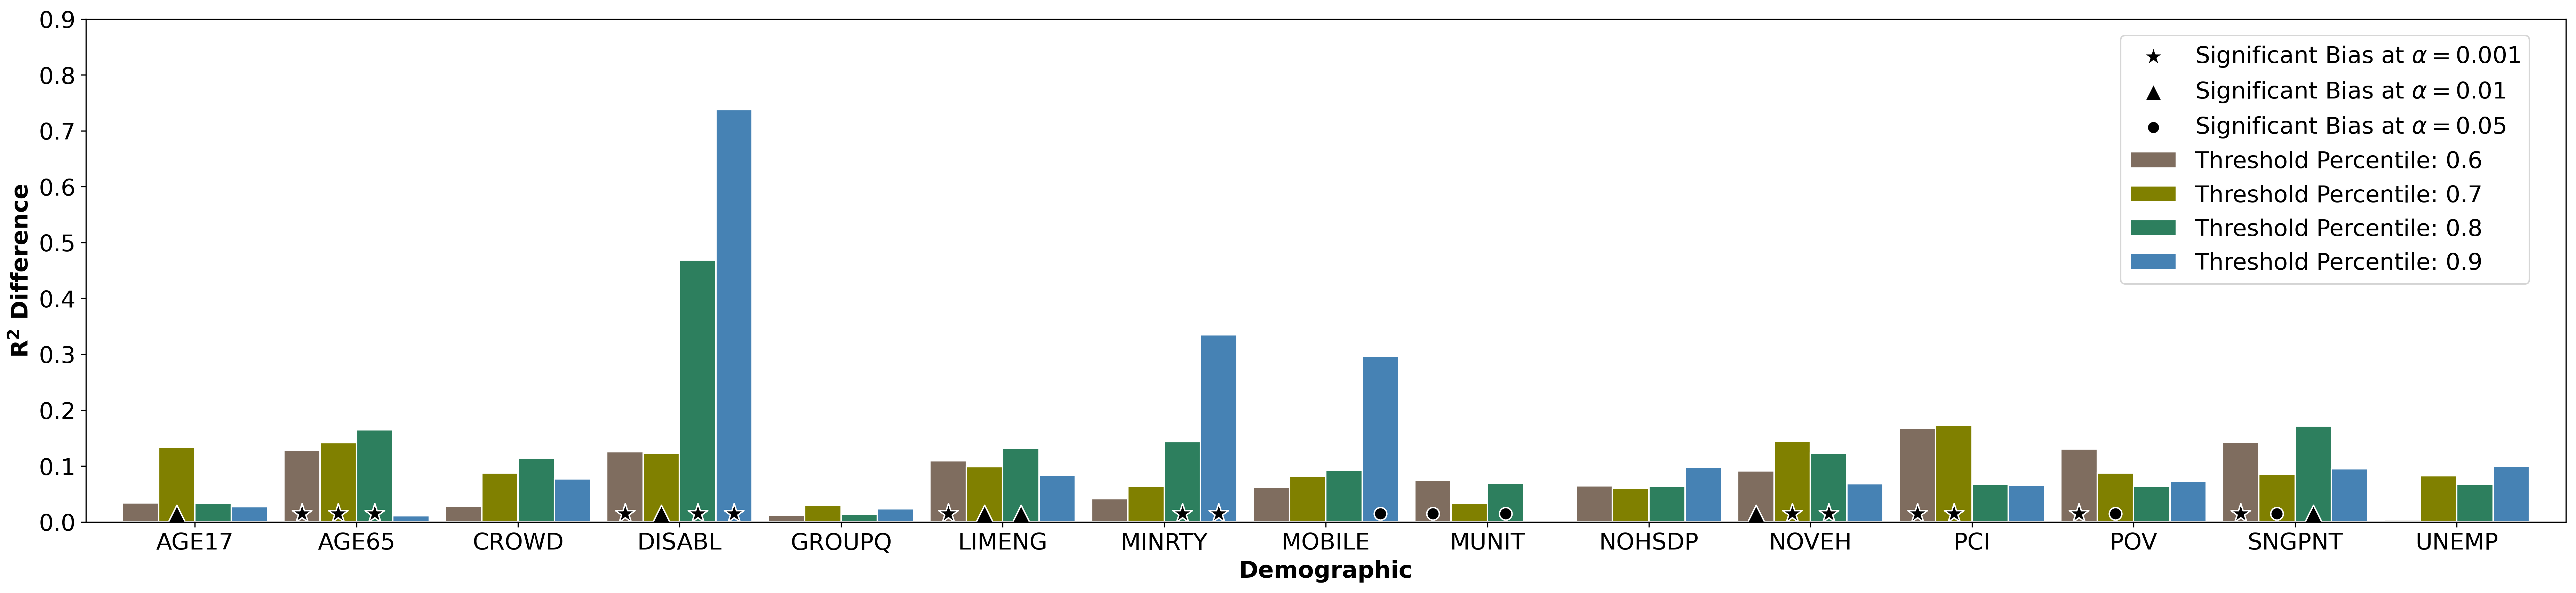

## Analysis

Clearly, adding gamma regularization influences the R2 difference across most of the protected demographic variables. We now need to visually evaluate the validity of the hypothesis - "regularizing on a specific protected variable inadvertantly increases bias in other protected variables."


- While the R2 difference in the $60^{th}$ percentile for AGE17 goes down by adding gamma regularizationo, the $70^{th}$, $80^{th}$, and $90^{th}$ percentile R2 difference goes up. This shows that overall, AGE17 is negatively impacted due to the addition of the gamma regularization.
- The same trend is observed for AGE65. Specifically, the $90^{th}$ percentile R2 difference goes down drastically after adding the gamma regularization, but the $60^{th}$, $70^{th}$, and $80^{th}$ percentile R2 differences go up. This shows and overall negative impact.
- CROWD is also negatively impacted by the gamma regularization. We see that the R2 difference across all the percentile groups goes up after adding regularization.
- DISABL exhibits a similar trend, but in an opposite way - Upon adding gamma regularization, the $60^{th}$ percentile R2 difference goes up, but the $70^{th}$, $80^{th}$, and $90^{th}$ percentile differences go down, indicating an overall positive effect.
- GROUPQ is positively impacted across all percentile groups - the R2 difference goes down after adding gamma regularization.
- For LIMENG, the $60^{th}$ and $70^{th}$ are positively affected as attributed by the decrease in their R2 difference, but the $80^{th}$ and $90^{th}$ are negatively impacted.
- Coming to the main feature on which the regularization is conditioned - MINRTY. We see an interesting phenomenon - while it is true that the overall R2 difference goes down after applying gamma regularization, we see that the unmasked gamma model *may* slightly perform better than the unmasked gamma model.
- MOBILE is positively impacted across all percentile groups as indicated by the decrease in R2 difference.
- MUNIT exhibits a positive impact across the $60^{th}$, $80^{th}$, and $90^{th}$ percentile groups, but seems to be negatively affected in the $70^{th}$ percentile. Additionally, this is another feature where the unmasked gamma model performs slightly better than the masked gamma model.
- NOHSDP R2 differences go up across all the percentile groups in the gamma models. This indicates a clear negative impact on the feature.
- For NOVEH, $60^{th}$, $70^{th}$, and $90^{th}$ percentile differences go up and $80^{th}$ percentile difference goes down, indicating an overall negative impact.
- For PCI, $60^{th}$ and $70^{th}$ percentile differences significantly go down, but $80^{th}$ and $80^{th}$ differences go up. Overall, the effect of regularization seems balanced.
- POV experiences the same trend as PCI does.
- For SNGPNT, other than the increase in the $90^{th}$ percentile R2 difference, the overall impact of adding regularization seems to be positive.
- Finally, for UNEMP, apart from the $60^{th}$ percentile, all other groups experience an increase in R2 difference. This illustrates an overall negative impact on the feature.


Based on the visual observations, it is hard to disprove the hypothesis.